In [0]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

In [0]:
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [132]:
!rm *.tgz *.png 
!wget https://www.dropbox.com/s/pppk3ltnci0damv/style.tgz
!tar xvzf style.tgz

--2018-05-17 15:24:51--  https://www.dropbox.com/s/pppk3ltnci0damv/style.tgz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/vTWdk6tJcLgjD7YLa6WWVtABtSfI8TvElRWPN8FJIwB6JgKMK2tKye38voxkIdQt/file [following]
--2018-05-17 15:24:51--  https://dl.dropboxusercontent.com/content_link/vTWdk6tJcLgjD7YLa6WWVtABtSfI8TvElRWPN8FJIwB6JgKMK2tKye38voxkIdQt/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.7.6, 2620:100:6016:6::a27d:106
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.7.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 899339 (878K) [application/x-gtar]
Saving to: ‘style.tgz’

style.tgz           100%[===================>] 878.26K  --.-KB/s    in 0.1s    

2018-05-17 15:24:52 (8.23 M

In [0]:
content_image=Image.open('upv.png')
content_image=content_image.resize((512,512))

In [0]:
style_image= Image.open('style.png')
style_image=style_image.resize((512,512))

In [0]:
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)

In [0]:
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)

print(content_array.shape)
print(style_array.shape)

In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68


In [0]:
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68


In [0]:
height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

In [0]:
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

In [150]:
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [0]:
content_weight = 0.05
style_weight = 50.0
total_variation_weight = 1.0

In [152]:
layers=dict([(layer.name, layer.output) for layer in model.layers])
print(layers)

{'block4_pool': <tf.Tensor 'block4_pool_4/MaxPool:0' shape=(3, 32, 32, 512) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool_4/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>, 'block4_conv1': <tf.Tensor 'block4_conv1_4/Relu:0' shape=(3, 64, 64, 512) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1_4/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2_4/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block4_conv2': <tf.Tensor 'block4_conv2_4/Relu:0' shape=(3, 64, 64, 512) dtype=float32>, 'block4_conv3': <tf.Tensor 'block4_conv3_4/Relu:0' shape=(3, 64, 64, 512) dtype=float32>, 'block5_conv2': <tf.Tensor 'block5_conv2_4/Relu:0' shape=(3, 32, 32, 512) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool_4/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>, 'block5_conv3': <tf.Tensor 'block5_conv3_4/Relu:0' shape=(3, 32, 32, 512) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1_4/Relu:0' shape=(3, 512, 512, 64) dtype=float32>

In [0]:
loss=backend.variable(0.)

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

In [155]:
layer_features=layers['block2_conv2']
print(layer_features.shape)
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss+=content_weight*content_loss(content_image_features,combination_features)

(3, 256, 256, 128)


In [0]:
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

In [0]:
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [0]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [0]:
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl

In [0]:
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = backend.gradients(loss, combination_image)

In [0]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [0]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [0]:
evaluator=Evaluator()

In [0]:
x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 10

In [167]:
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
326679900000.0
Iteration 0 completed in 18s
Start of iteration 1
161514470000.0
Iteration 1 completed in 17s
Start of iteration 2
115220636000.0
Iteration 2 completed in 17s
Start of iteration 3
93285930000.0
Iteration 3 completed in 17s
Start of iteration 4
79982460000.0
Iteration 4 completed in 17s
Start of iteration 5
71665390000.0
Iteration 5 completed in 17s
Start of iteration 6
66985943000.0
Iteration 6 completed in 17s
Start of iteration 7
63590040000.0
Iteration 7 completed in 17s
Start of iteration 8
60878647000.0
Iteration 8 completed in 17s
Start of iteration 9
59158725000.0
Iteration 9 completed in 17s


In [0]:
print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')


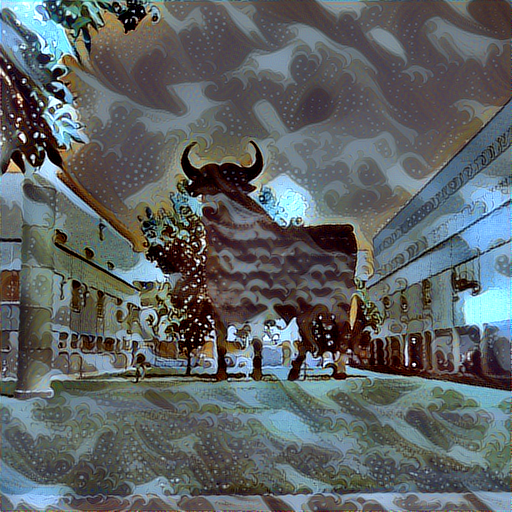

In [169]:
Image.fromarray(x)